In [1]:
from torch import optim
import os
import torchvision.utils as vutils
import numpy as np
import math
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
def show(data, row, col):
    len1 = data.shape[0]
    len2 = row * col
    for i in range(min(len1, len2)):
        plt.subplot(row, col, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(data[i].squeeze())
    plt.show()

In [3]:
# 参数设置
BATCH_SIZE = 256 #批次大小
EPOCHS = 500 #迭代轮数
Z_DIM = 30 # 隐藏变量维度
LOAD_MODEL = False #是否加载模型
CHANNELS = 1 #图像通道数
DB =   'MNIST' # [ MNIST | FashionMNIST | USPS ]

# 图片的维度 size*size
if DB == 'MNIST' or DB == 'FashionMNIST':
    IMAGE_SIZE = 28
elif DB == 'USPS':
    IMAGE_SIZE = 16
else:
    print("Incorrect dataset")
    exit(0)

if not IMAGE_SIZE % 4 == 0:
    print("Incompatible Image size")
    exit(0)

In [7]:
# 存储模型和输出图像的地址
model_path = os.path.join('./out/model', DB) #模型地址
if not os.path.exists(model_path): #若无地址则创建
    os.makedirs(model_path)
samples_path = os.path.join('./out/samples', DB)
if not os.path.exists(samples_path):
    os.makedirs(samples_path)
db_path = os.path.join('./data', DB)
if not os.path.exists(samples_path):
    os.makedirs(samples_path)

In [5]:
# 存储图像的函数 
def generate_imgs(z, epoch=0):
    gen.eval() # 打开评估模式 
    fake_imgs = gen(z) # 从 z 隐藏变量 通过生成器 变成 x
    fake_imgs_ = vutils.make_grid(fake_imgs, normalize=True, nrow=math.ceil(BATCH_SIZE ** 0.5))  #将生成的图像进行排列
    vutils.save_image(fake_imgs_, os.path.join(samples_path, 'sample_' + str(epoch) + '.png'))

In [6]:
# 图像变换
mean = np.array([0.5])
std = np.array([0.5])
transform = transforms.Compose([transforms.Resize([IMAGE_SIZE, IMAGE_SIZE]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

In [8]:
# 加载图像
if DB=='MNIST':
    dataset = datasets.MNIST(db_path, train=True, download=True, transform=transform)
elif DB=='FashionMNIST':
    dataset = datasets.FashionMNIST(db_path, train=True, download=False, transform=transform)
elif DB=='USPS':
    dataset = datasets.USPS(db_path, train=True, download=True, transform=transform)

0it [00:00, ?it/s]

9920512it [00:02, 3781057.29it/s]                                                              
0it [00:00, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


32768it [00:00, 277030.99it/s]                                                                 
  0%|                                                              | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw


1654784it [00:00, 3266620.58it/s]                                                              
8192it [00:00, 75006.85it/s]                                                                   


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw
Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw
Processing...


/home/rain/anaconda3/envs/MVADG/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [9]:
# 将数据载入迭代器
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)

In [10]:
# 卷积块
def conv_block(c_in, c_out, k_size=4, stride=2, pad=1, use_bn=True, transpose=False):
    module = []
    if transpose:
        module.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=not use_bn))
    else:
        module.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=not use_bn))
    if use_bn:
        module.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*module)

In [11]:
#生成器模块 对于MNIST数据集 其为default parameter
class Generator(nn.Module):
    def __init__(self, z_dim=10, image_size=28, channels=1, conv_dim=8):
        super(Generator, self).__init__()
        self.image_size = image_size

        self.fc1 = nn.Linear(z_dim,  (self.image_size//4)*(self.image_size//4)*conv_dim*2)
        self.tconv2 = conv_block(conv_dim * 2, conv_dim, transpose=True, use_bn=True)
        self.tconv3 = conv_block(conv_dim, channels, transpose=True, use_bn=False)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = x.reshape([x.shape[0], -1, self.image_size//4, self.image_size//4])
        x = F.relu(self.tconv2(x))
        x = torch.tanh(self.tconv3(x))
        return x


class Discriminator(nn.Module):
    def __init__(self, image_size=28, channels=1, conv_dim=8):
        super(Discriminator, self).__init__()
        self.conv1 = conv_block(channels, conv_dim, use_bn=False)
        self.conv2 = conv_block(conv_dim, conv_dim * 2, use_bn=True)
        self.fc3 = nn.Linear((image_size//4)*(image_size//4)*conv_dim*2, 1)

    def forward(self, x):
        alpha = 0.2
        x = F.leaky_relu(self.conv1(x), alpha)
        x = F.leaky_relu(self.conv2(x), alpha)
        x = x.reshape([x.shape[0], -1])
        x = torch.sigmoid(self.fc3(x))
        return x.squeeze()

In [12]:
gen = Generator(z_dim=Z_DIM, image_size=IMAGE_SIZE, channels=CHANNELS)
dis = Discriminator(image_size=IMAGE_SIZE, channels=CHANNELS)

In [13]:
if LOAD_MODEL:
    gen.load_state_dict(torch.load(os.path.join(model_path, 'gen.pkl')))
    dis.load_state_dict(torch.load(os.path.join(model_path, 'dis.pkl')))
    z = torch.randn(BATCH_SIZE, Z_DIM)
    fake_imgs = gen(z)
    show(fake_imgs[:25].detach().numpy(), 5, 5)
    exit(0)


# 模型参数细节
print("------------------Generator------------------")
print(gen)
print("------------------Discriminator------------------")
print(dis)

# 使用Adam优化器
g_opt = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)
d_opt = optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)

# 损失函数Binary Cross Entropy
loss_fn = nn.BCELoss()

# 采样
fixed_z = torch.randn(BATCH_SIZE, Z_DIM)

# 赋值
real_label = torch.ones(BATCH_SIZE)
fake_label = torch.zeros(BATCH_SIZE)

------------------Generator------------------
Generator(
  (fc1): Linear(in_features=30, out_features=784, bias=True)
  (tconv2): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv3): Sequential(
    (0): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)
------------------Discriminator------------------
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc3): Linear(in_features=784, out_features=1, bias=True)
)


In [14]:
# 设置GPU
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda:1")  # 指定使用cuda:1设备
    gen = gen.to(device)
    dis = dis.to(device)
    real_label = real_label.to(device)
    fake_label = fake_label.to(device)
    fixed_z = fixed_z.to(device)

total_iters = 0
max_iter = len(data_loader)

In [15]:
# 训练
for epoch in range(EPOCHS):
    # 开启训练模式
    gen.train()
    dis.train()
    
    # 对取出数据迭代器中每一个批次
    for i, data in enumerate(data_loader):
        total_iters += 1

        # 加载数据
        x_real, _ = data
        z_fake = torch.randn(BATCH_SIZE, Z_DIM)

        if is_cuda:
            x_real = x_real.to(device)
            z_fake = z_fake.to(device)

        # 生成样本
        x_fake = gen(z_fake)

        # 训练判别器
        fake_out = dis(x_fake.detach())
        real_out = dis(x_real.detach())
        d_loss = (loss_fn(fake_out, fake_label) + loss_fn(real_out, real_label)) / 2

        d_opt.zero_grad()
        d_loss.backward()
        d_opt.step()

        # 训练生成器
        fake_out = dis(x_fake)
        g_loss = loss_fn(fake_out, real_label)

        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

        if i % 50 == 0:
            print("Epoch: " + str(epoch + 1) + "/" + str(EPOCHS)
                  + "\titer: " + str(i) + "/" + str(max_iter)
                  + "\ttotal_iters: " + str(total_iters)
                  + "\td_loss:" + str(round(d_loss.item(), 4))
                  + "\tg_loss:" + str(round(g_loss.item(), 4))
                  )

    if (epoch+1) % 5 == 0:
        torch.save(gen.state_dict(), os.path.join(model_path, 'gen.pkl'))
        torch.save(dis.state_dict(), os.path.join(model_path, 'dis.pkl'))

        generate_imgs(fixed_z, epoch=epoch + 1)

generate_imgs(fixed_z)

Epoch: 1/500	iter: 0/234	total_iters: 1	d_loss:0.7086	g_loss:0.5863
Epoch: 1/500	iter: 50/234	total_iters: 51	d_loss:0.376	g_loss:0.9844
Epoch: 1/500	iter: 100/234	total_iters: 101	d_loss:0.2798	g_loss:1.3187
Epoch: 1/500	iter: 150/234	total_iters: 151	d_loss:0.1712	g_loss:1.8376
Epoch: 1/500	iter: 200/234	total_iters: 201	d_loss:0.123	g_loss:2.2144
Epoch: 2/500	iter: 0/234	total_iters: 235	d_loss:0.0885	g_loss:2.6085
Epoch: 2/500	iter: 50/234	total_iters: 285	d_loss:0.0849	g_loss:2.6509
Epoch: 2/500	iter: 100/234	total_iters: 335	d_loss:0.0656	g_loss:2.8824
Epoch: 2/500	iter: 150/234	total_iters: 385	d_loss:0.0608	g_loss:3.0382
Epoch: 2/500	iter: 200/234	total_iters: 435	d_loss:0.0592	g_loss:2.9768
Epoch: 3/500	iter: 0/234	total_iters: 469	d_loss:0.0501	g_loss:3.2435
Epoch: 3/500	iter: 50/234	total_iters: 519	d_loss:0.0634	g_loss:3.0003
Epoch: 3/500	iter: 100/234	total_iters: 569	d_loss:0.0988	g_loss:2.3307
Epoch: 3/500	iter: 150/234	total_iters: 619	d_loss:0.0793	g_loss:3.1197
Epoch:

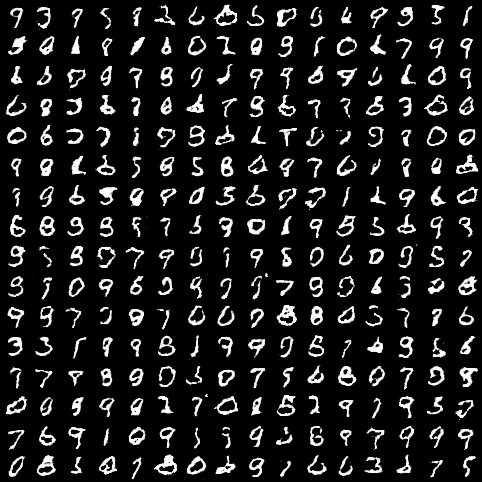

In [10]:
from IPython.display import Image

def show_png_image(file_path):
    return Image(file_path)

# 示例用法
show_png_image("./out/samples/MNIST/sample_495.png")